# Description:

* Making an example of HR-SIP analysis for ASM poster (and other presentations)

# Init

In [2]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome4/'
genomeDir = '/home/nick/notebook/SIPSim/t/genome_data/'

In [1]:
import os,sys
import numpy as np
import pandas as pd

In [12]:
%matplotlib inline
%load_ext rpy2.ipython

In [13]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid


# Dataset

* Clostridium_perfringens_str__13_DNA
* Bacillus_subtilis_PY79
* Corynebacterium_casei_LMG_S_19264
* Myxococcus_stipitatus_DSM_14675

## Symlinking genomes

In [7]:
genomeSymlinkDir = os.path.join(workDir, 'genome_data')

if not os.path.isdir(genomeSymlinkDir):
    os.mkdir(genomeSymlinkDir)

In [11]:
!cd $workDir; \
    cut -f 1 genome_list.txt | \
    xargs -n 1 -I % ln -s -f $genomeDir/%.fasta $genomeSymlinkDir/%.fna
    
!cd $workDir; \
    ls -thlc $genomeSymlinkDir

total 16K
lrwxrwxrwx 1 nick nick 75 May 19 12:03 Bacillus_subtilis_PY79.fna -> /var/seq_data/ncbi_db/genome/prok-bac-genomes//Bacillus_subtilis_PY79.fasta
lrwxrwxrwx 1 nick nick 86 May 19 12:03 Corynebacterium_casei_LMG_S-19264.fna -> /var/seq_data/ncbi_db/genome/prok-bac-genomes//Corynebacterium_casei_LMG_S-19264.fasta
lrwxrwxrwx 1 nick nick 84 May 19 12:03 Myxococcus_stipitatus_DSM_14675.fna -> /var/seq_data/ncbi_db/genome/prok-bac-genomes//Myxococcus_stipitatus_DSM_14675.fasta
lrwxrwxrwx 1 nick nick 83 May 19 12:03 Clostridium_perfringens_str_13.fna -> /var/seq_data/ncbi_db/genome/prok-bac-genomes//Clostridium_perfringens_str_13.fasta


# Indexing genomes

In [32]:
!cd $workDir; \
    SIPSim indexGenomes genome_list.txt \
    --fp ./genome_data/ --np 4 > genome_data/index_log.txt

Indexing: "Clostridium_perfringens_str_13"
Indexing: "Bacillus_subtilis_PY79"
Indexing: "Corynebacterium_casei_LMG_S-19264"
Indexing: "Myxococcus_stipitatus_DSM_14675"


# Simulating fragments

In [53]:
!cd $workDir; \
    SIPSim fragments \
    genome_list.txt \
    --fp genome_data \
    --fr ../515Fm-927Rm.fna \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np 4 \
    2> ampFrag_skewN90-25-n5-nS.log \
    > ampFrag_skewN90-25-n5-nS.pkl
    
!cd $workDir; \
    tail ampFrag_skewN90-25-n5-nS.log

  Genome length (bp): 4033459
  Number of amplicons: 10
  Number of fragments simulated: 10000
  Genome name: Clostridium_perfringens_str_13
  Genome length (bp): 10350586
  Number of amplicons: 3
  Number of fragments simulated: 10000
  Genome length (bp): 3031430
  Number of amplicons: 9
  Number of fragments simulated: 10000


# Converting to 2d-kde objects

* Also converts fragment G+C to buoyant density

In [54]:
!cd $workDir; \
    SIPSim fragment_kde \
    ampFrag_skewN90-25-n5-nS.pkl \
    > ampFrag_skewN90-25-n5-nS_kde.pkl

# Adding diffusion

In [55]:
!cd $workDir; \
    SIPSim diffusion \
    ampFrag_skewN90-25-n5-nS_kde.pkl \
    --np 4 \
    > ampFrag_skewN90-25-n5-nS_dif_kde.pkl

Processing: Myxococcus_stipitatus_DSM_14675
Processing: Bacillus_subtilis_PY79
Processing: Clostridium_perfringens_str_13
Processing: Corynebacterium_casei_LMG_S-19264


# Creating a community file

In [59]:
!cd $workDir; \
    SIPSim gradientComms \
    genome_list.txt \
    --abund_dist uniform \
    --abund_dist_p low:45,high:55 \
    --n_comm 2 \
    > comm_n2.txt
    
!cd $workDir; \
    head comm_n2.txt

library	taxon_name	rel_abund_perc	rank
1	Bacillus_subtilis_PY79	27.242559571	1
1	Corynebacterium_casei_LMG_S-19264	25.443466833	2
1	Clostridium_perfringens_str_13	23.932618755	3
1	Myxococcus_stipitatus_DSM_14675	23.381354841	4
2	Bacillus_subtilis_PY79	26.035282022	1
2	Corynebacterium_casei_LMG_S-19264	25.462998714	2
2	Clostridium_perfringens_str_13	24.941764749	3
2	Myxococcus_stipitatus_DSM_14675	23.559954514	4


# Setting isotope incorporation

* Using a Montel Carlo method to determine how the BD distribution is altered by % isotope incorporation

In [63]:
# making config file
config = """
[1]
  # baseline: no incorp
  
  [[intraPopDist 1]]
  distribution = uniform

    [[[start]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0

    [[[end]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0
        
[2]
  # split inter-pop distribution (~30% of taxa have ~100% incorp)
  
  [[intraPopDist 1]]
  distribution = normal

    [[[mu]]]

      # these taxa get full incorp
      [[[[interPopDist 1]]]]
        weight = 0.2
        distribution = uniform
        start = 100
        end = 100

      # these taxa in the community get no incorp
      [[[[interPopDist 2]]]]
        weight = 0.8      
        distribution = uniform
        start = 0
        end = 0

    [[[sigma]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0     
               
"""

outfile = os.path.join(workDir, 'incorp.config')

outf = open(outfile, 'wb')
outf.write(config)
outf.close()

In [64]:
!cd $workDir; \
    SIPSim isoIncorp \
    ampFrag_skewN90-25-n5-nS_dif_kde.pkl \
    incorp.config \
    --comm comm_n2.txt \
    --np 4 \
    > incorp_n2.pkl

Processing: Myxococcus_stipitatus_DSM_14675
Processing: Bacillus_subtilis_PY79
Processing: Clostridium_perfringens_str_13
Processing: Corynebacterium_casei_LMG_S-19264
Processing: Myxococcus_stipitatus_DSM_14675
Processing: Bacillus_subtilis_PY79
Processing: Clostridium_perfringens_str_13
Processing: Corynebacterium_casei_LMG_S-19264


## Calculating BD shift from incorporation 

* KDEs: 
  * BD-diffusion
  * BD-diffusion-isoIncorp
* BD_shift = 1 - KDE_intersection

In [65]:
!cd $workDir; \
    SIPSim BD_shift \
    ampFrag_skewN90-25-n5-nS_dif_kde.pkl \
    incorp_n2.pkl \
    --np 4 

Loading KDE objects...
Calculating BD shifts...
lib1	lib2	taxon	BD_shift
  Comparing libraries; "NA", "1"
NA	1	Myxococcus_stipitatus_DSM_14675	0.0056147172893
NA	1	Bacillus_subtilis_PY79	0.0035786920298
NA	1	Clostridium_perfringens_str_13	0.00566424849526
NA	1	Corynebacterium_casei_LMG_S-19264	0.00708686457591
  Comparing libraries; "NA", "2"
NA	2	Myxococcus_stipitatus_DSM_14675	0.00561471728875
NA	2	Bacillus_subtilis_PY79	0.0035786920302
NA	2	Clostridium_perfringens_str_13	0.999571486049
NA	2	Corynebacterium_casei_LMG_S-19264	0.00708686457571


# Simulating gradient fractions

In [67]:
!cd $workDir; \
    SIPSim fractions \
    comm_n2.txt \
    > fracs_n2.txt
    
!cd $workDir; \
    head fracs_n2.txt

library	fraction	BD_min	BD_max	fraction_size
1	1	1.66	1.664	0.004
1	2	1.664	1.669	0.005
1	3	1.669	1.674	0.005
1	4	1.674	1.682	0.008
1	5	1.682	1.685	0.003
1	6	1.685	1.691	0.006
1	7	1.691	1.694	0.003
1	8	1.694	1.699	0.005
1	9	1.699	1.707	0.008


# Making an OTU table

* Using community file to draw n samples from the respective BD KDE 
* The BD values are binning by fraction
* A table is created of all fractions

In [68]:
!cd $workDir; \
    SIPSim OTU_table \
    incorp_n2.pkl \
    comm_n2.txt \
    fracs_n2.txt \
    --abs 1e9 \
    --np 4 \
    > OTU_n2_abs1e9.txt

Loading files...
Simulating OTUs...
Processing library: "1"
  Processing taxon: "Bacillus_subtilis_PY79"
   taxon abs-abundance:  272425596
  Processing taxon: "Corynebacterium_casei_LMG_S-19264"
   taxon abs-abundance:  254434668
  Processing taxon: "Clostridium_perfringens_str_13"
   taxon abs-abundance:  239326188
  Processing taxon: "Myxococcus_stipitatus_DSM_14675"
   taxon abs-abundance:  233813548
Processing library: "2"
  Processing taxon: "Bacillus_subtilis_PY79"
   taxon abs-abundance:  260352820
  Processing taxon: "Corynebacterium_casei_LMG_S-19264"
   taxon abs-abundance:  254629987
  Processing taxon: "Clostridium_perfringens_str_13"
   taxon abs-abundance:  249417647
  Processing taxon: "Myxococcus_stipitatus_DSM_14675"
   taxon abs-abundance:  235599545


# Subsampling samples

* simulating sequencing from DNA libraries (OTU table)
* sampling with replacement

In [77]:
!cd $workDir;\
    SIPSim OTU_subsample \
    --dist_params low:50000,high:50000 \
    OTU_n2_abs1e9.txt \
    > OTU_n2_abs1e9_sub50k.txt

## Plotting OTU distributions

In [80]:
%%R -i workDir

setwd(workDir)

tbl.sub = read.delim('OTU_n2_abs1e9_sub50k.txt')

tbl.sum = tbl.sub %>%
    group_by(library, fraction) %>%
    summarize(fraction_sum = sum(count))

## samples with no subsamples
tbl.sum %>% filter(fraction_sum < 10000) %>% print

## filtering
tbl.sub = tbl.sub %>% 
    filter(!grepl('inf', fraction, ignore.case=T)) %>%
    separate(fraction, into = c('BD_min','BD_max'), sep='-', convert=TRUE) %>%
    filter(BD_min != 1.795) %>%
    mutate(
        BD_min = as.numeric(BD_min),
        BD_max = as.numeric(BD_max),
        BD_mean = (BD_min + BD_max) / 2
        ) %>% as.data.frame

Source: local data frame [0 x 3]
Groups: library

Variables not shown: library (int), fraction (fctr), fraction_sum (int)


In [81]:
%%R
# ordering taxa by total abundances
tax_order = tbl.sub %>%
    group_by(taxon) %>%
    summarize(taxon_total_abund = sum(count)) %>%
    as.data.frame

tax_order = unique(tax_order[order(tax_order$taxon_total_abund, decreasing=T),'taxon']) 

tbl.sub$taxon = factor(tbl.sub$taxon, levels=sort(unique(tbl.sub$taxon), decreasing=T))
tbl.sub$taxon_group = factor(tbl.sub$taxon, levels=tax_order)

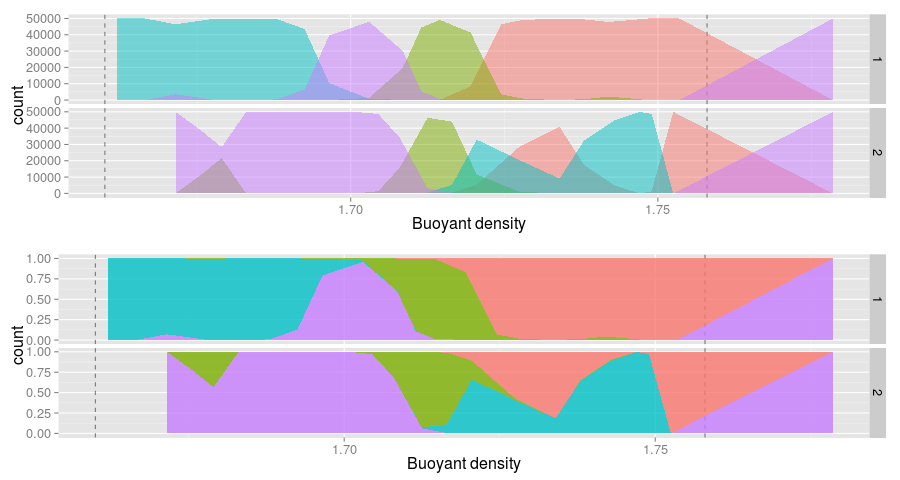

In [82]:
%%R -w 900
## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

## plotting
p = ggplot(tbl.sub, aes(BD_mean, count, fill=taxon, group=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p1 = p + geom_area(stat='identity', alpha=0.5, position='dodge') 
p2 = p + geom_area(stat='identity', alpha=0.8, position='fill') 

grid.arrange(p1, p2, ncol=1)

In [98]:
%%R
# functions for relabeling facet labels
label_change <- function(value){
    if (value == 1){
        return(expression(paste(""^12, "C control")))        
        } else 
    if (value == 2){
        return(expression(paste(""^13, "C treatment")))
        } else {
        return(value)
        }
    }

# facet labeling function
label_facet <- function(variable, value) {
    sapply(as.character(value), label_change)
}  
    

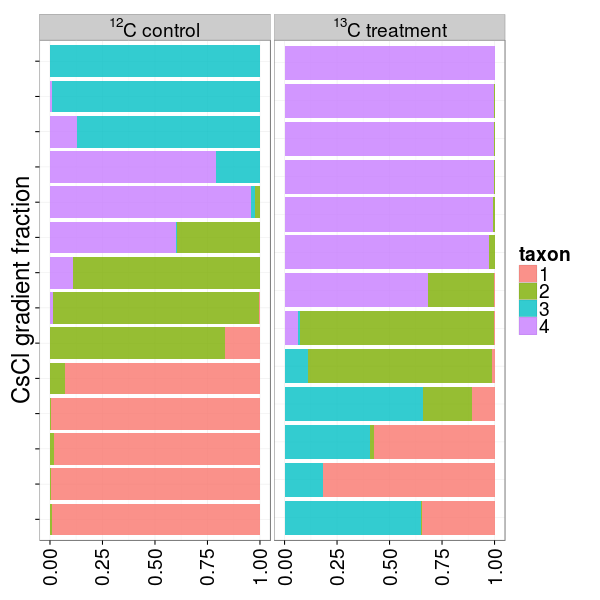

In [160]:
%%R -w 600 -h 600
## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

# edit table
tbl.sub.sum = tbl.sub %>% 
    group_by(BD_mean) %>%
    summarize(total = sum(count)) %>%
    filter(total > c(0))
            
tbl.sub2 = tbl.sub %>%
    filter(BD_mean %in% tbl.sub.sum$BD_mean) %>%
    filter(BD_mean > 1.68, BD_mean < 1.74) %>%
    mutate(taxon = as.character(as.numeric(taxon))) %>%
    mutate(BD_mean_char = as.character(BD_mean)) #%>%
    #arrange(desc(BD_mean))

tbl.sub2$BD_mean_char = reorder(tbl.sub2$BD_mean_char, rev(tbl.sub2$BD_mean))

    

## plotting
p = ggplot(tbl.sub2, aes(BD_mean_char, count, fill=taxon, group=taxon)) +
    geom_bar(stat='identity', alpha=0.8, position='fill') +
    coord_flip() +
    labs(x='CsCl gradient fraction', y='Relative abundance') +
    facet_grid(. ~ library, scales='free_x', labeller=label_facet) +
    theme_bw() +
    theme( 
        text = element_text(size=24),
        axis.title.x = element_blank(),
        axis.text.x = element_text(vjust=0.5, angle=90),
        axis.text.y = element_blank(),
        panel.background = element_blank(),
        rect = element_rect(fill = "transparent",colour = NA)        
    )
p

In [161]:
%%R
setwd('/home/nick/notebook/fullCyc/figures/HR-SIP_examples/')
ggsave('taxon4_inc100.pdf', width=6, height=6)